In [1]:
import os
import sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pickle

In [2]:
%load_ext autoreload
%autoreload 2

In [58]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.preprocessing import select_nodes, to_param_dict, to_param_list, insert_zero_params, rescale_manybody_params
from statmechlib.preprocessing import Trajectory, find_index, pair_dist_cutoff, universal_eos
from statmechlib.forcefields import utot_EAM_per_atom, utot_EAM_per_box, udif_print, u_core

In [4]:
target_proc = '../data/target_processed'
working = '../data/working'
reports = '../reports'

In [5]:
params_file = 'marinica_params'
stats_file = 'stats_marinica'
target_file = 'target_marinica'
stats_file = 'stats_manyknots' # 'stats_samples'
target_file = 'target_manyknots' # 'target_samples'
params_file = 'marinica_params'
stats_file = 'stats_manymd' # 'stats_samples'
target_file = 'target_manymd' # 'target_samples'
#stats_file = 'stats_manyvac' # 'stats_samples'
#target_file = 'target_manyvac' # 'target_samples'

In [6]:
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_all = pickle.load(fi)

with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi)

with open(os.path.join(working, params_file + '.pickle'), 'rb') as fi:
    param_list = pickle.load(fi)  

In [7]:
def find_index(select_list, full_list):
    knots = []
    for sel in select_list:
        for i, elem in enumerate(full_list):
            if abs(sel - elem) < 1e-9:
                knots.append(i)
                break
    
    assert len(knots) == len(select_list), "Knots and select_list lengths do not match"
    
    return knots

In [7]:
# extended knots
pair_knots = [ 2.45, 2.5648975,  2.629795 ,  2.6946925,  2.8663175,  2.973045 ,
        3.0797725,  3.5164725,  3.846445 ,  4.1764175,  4.700845 ,
        4.8953   ,  5.089755 ,  5.3429525,  5.401695 ,  5.4604375, 5.78]
edens_knots = [ 2.5,  3.1,  3.5,  4.9, 5.5]

pair_knots = [ 2.5648975,  2.629795 ,  2.6946925,  2.8663175,  2.973045 ,
        3.0797725,  3.5164725,  3.846445 ,  4.1764175,  4.700845 ,
        4.8953   ,  5.089755 ,  5.3429525,  5.401695 ,  5.4604375]
edens_knots = [ 2.5,  3.1,  3.5,  4.9]

pair_index = find_index(pair_knots, stats_all['hyperparams']['pair'])
edens_index = find_index(edens_knots, stats_all['hyperparams']['edens'])
print('pair_index:', pair_index)
print('edens_index:', edens_index)

('pair_index:', [6, 9, 11, 17, 20, 24, 36, 45, 54, 69, 74, 80, 88, 90, 93])
('edens_index:', [4, 25, 35, 75])


In [9]:
# selecty spline knots
#pair_index = [1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 15, 16, 17, 18]
#multibody_index = [0, 7, 8, 14]

p_ix = np.array([True if i in pair_index else False for i in range(len(stats_all['hyperparams']['pair']))])
m_ix = np.array([True if i in edens_index else False for i in range(len(stats_all['hyperparams']['edens']))])

stats = select_nodes(stats_all, p_ix, m_ix)

print("pair:", np.array(stats_all['hyperparams']['pair'])[p_ix])
print("edens:", np.array(stats_all['hyperparams']['edens'])[m_ix])
print('pars', param_list[0]['hyperparams'])

('pair:', array([ 2.5648975,  2.629795 ,  2.6946925,  2.8663175,  2.973045 ,
        3.0797725,  3.5164725,  3.846445 ,  4.1764175,  4.700845 ,
        4.8953   ,  5.089755 ,  5.3429525,  5.401695 ,  5.4604375]))
('edens:', array([ 2.5,  3.1,  3.5,  4.9]))
('pars', {u'pair': [2.5648974999999998, 2.6297950000000001, 2.6946924999999999, 2.8663175000000001, 2.9730449999999999, 3.0797724999999998, 3.5164724999999999, 3.8464450000000001, 4.1764175000000003, 4.7008450000000002, 4.8952999999999998, 5.0897550000000003, 5.3429525, 5.4016950000000001, 5.4604375000000003], u'edens': [2.5, 3.1, 3.5, 4.9]})


In [136]:
optimal_params = []
for params in param_list:
    eam_params = list(params['params']['embed']) + list(params['params']['pair']) + list(params['params']['edens'])
    #eam_params = list(params['params']['embed']) + [0.0] + list(params['params']['pair']) + [0.0] + list(params['params']['edens']) + [0.0]
    optimal_params.append((0.0, np.array(eam_params)))

In [140]:
optimal_params[0][1][-4] = -4.20429107805

In [141]:
optimal_params

[(0.0, array([ -5.94645400e+00,  -4.94770000e-02,   9.60851701e+01,
          -1.84410924e+02,   9.35784080e+01,  -7.98358265e+00,
           7.47034093e+00,  -1.52756044e+00,   1.25205933e+00,
           1.63082162e+00,  -1.41854775e+00,  -8.19936046e-01,
           1.98013514e+00,  -6.96430180e-01,   3.04546910e-02,
          -1.63131143e+00,   1.38409896e+00,  -4.20429108e+00,
           5.18217702e-01,   5.62720800e-02,   3.44164179e-02]))]

In [142]:
# optimal_params.append((3.0674198658721691e-06, np.array([ -8.15036857e+00,  -1.34492508e-01,  -6.40562492e+02,
#         5.60045606e+02,  -1.62774419e+02,  -2.42163837e+01,
#         4.61349632e+01,  -1.21579989e+01,   6.09852042e-01,
#         1.39564841e+00,  -1.26608655e+00,  -7.44806685e-01,
#         2.00404873e+00,  -6.91376693e-01,   2.17652121e-02,
#        -1.61632910e+00,   1.37087609e+00,  -3.76175083e+01,
#         1.56626002e+00,  -1.74622706e-01,   3.14905374e-02])))
# optimal_params.append((2.2036185726499669e-06, np.array([ -6.70205913e+00,  -3.86729923e-02,  -6.36660911e+02,
#         7.48522323e+02,  -3.02289981e+02,   2.43903738e+01,
#         7.99267764e+00,  -5.00288982e+00,   3.98363657e-01,
#         1.18177686e+00,  -1.04440728e+00,  -7.34361783e-01,
#         2.03940754e+00,  -7.33324453e-01,   3.22601497e-02,
#        -1.68659097e+00,   1.39384190e+00,  -2.87086061e+01,

# 6.41466635e-01,  -5.25140182e-02,   3.13551914e-02])))
# optimal_params.append((1.9883954014792284e-06, np.array([ -6.67892458e+00,  -6.69057233e-02,  -7.88558288e+02,
#         8.64431119e+02,  -3.22117669e+02,   1.66223488e+01,
#         1.61253439e+01,  -7.08057431e+00,   3.36500438e-01,
#         1.23818786e+00,  -9.77125576e-01,  -7.10990440e-01,
#         1.96923157e+00,  -7.11735164e-01,   3.61922715e-02,
#        -1.61997750e+00,   1.35041921e+00,  -3.71430662e+01,
#         8.77780820e-01,  -5.71131123e-02,   3.98140807e-02])))
# optimal_params.append((0.0060326797097461976, np.array([ -8.13172851e+00,  -4.49702864e-02,   2.89657061e+02,
#         2.29284083e+01,  -3.62538768e+01,  -6.67077747e+00,
#        -5.21912803e+00,   3.34636693e+01,  -3.38738650e+00,
#         2.82512503e+00,  -2.35344355e+00,  -7.16503843e-01,
#         1.59333800e+00,  -1.52959697e-01,   3.37225608e-01,
#        -1.78309053e+00,   1.15621335e+00,   1.17451654e+02,
#         4.91780708e+00,  -8.03507275e-01,   3.10859811e-02])))
# optimal_params.append((0.0055046101872456114, np.array([ -8.27482341e+00,  -3.58322595e-02,  -3.04931926e+02,
#         2.67354545e+02,  -9.47559604e+01,  -6.28915309e+00,
#        -1.82080960e+00,   3.06675235e+01,  -3.02847087e+00,
#         2.68338299e+00,  -2.19529465e+00,  -7.72234170e-01,
#         1.46121652e+00,  -3.18762321e-02,   3.53838361e-01,
#        -1.78610521e+00,   1.13977276e+00,  -4.53379067e+01,
#         4.96626231e+00,  -7.84202283e-01,   3.18065305e-02])))
# optimal_params.append((0.0053604082908782083, np.array([ -9.42391613e+00,  -4.24391684e-02,  0.0, -2.94587357e+02,
#         2.70972700e+02,  -1.04787033e+02,  -2.98238182e+00,
#        -4.35229417e-01,   2.92307252e+01,  -3.93677905e+00,
#         3.09415379e+00,  -2.40064822e+00,  -8.22415578e-01,
#         1.49304711e+00,  -3.38081838e-02,   3.54435455e-01,
#        -1.76673992e+00,   1.15161862e+00,  0.0, -3.15350855e+01,
#         4.07693197e+00,  -7.52508632e-01,   3.10740894e-02, 0.0])))
# optimal_params.append((0.0022761996890569578, np.array([ -3.77590492e+00,  -1.16300006e-03,   5.84788559e+02,
#         -1.18968908e+02,   2.57663555e+02,  -1.11700585e+02,
#         -4.41069871e+00,   8.31759060e-01,   2.25589667e+01,
#         -7.29378311e+00,   7.50757832e+00,  -3.44935685e+00,
#         -6.89323571e-01,   1.12145202e+00,  -3.97761235e-01,
#          3.04014527e-01,  -1.66999650e+00,   1.65464460e+00,
#         -1.72777177e-01,   4.64906214e+02,   1.40386233e+01,
#         -2.01752844e+00,   2.68045065e-02,   3.86251315e-02])))
# optimal_params.append((0.00093953853450417092, np.array([ -9.03699707e+00,  -5.09767650e-02,  -2.18401511e-01,
#        -2.20639200e+02,   2.35340857e+02,  -8.86794492e+01,
#         3.33042935e+00,  -1.73170753e+01,   3.89683369e+01,
#        -3.62979727e+00,   2.62701453e+00,  -2.39880858e+00,
#        -7.83415512e-01,   1.46626900e+00,  -1.98490050e-02,
#         3.67087040e-01,  -1.73689278e+00,   1.13593236e+00,
#        -2.18095252e-02,  -7.29502441e+00,   4.33357052e+00,
#        -8.42945335e-01,   2.94745276e-02,   3.97488334e-04])))
# optimal_params.append((0.00067017901957554487, np.array([ -1.03168691e+01,  -1.88829016e-02,   1.01750064e+01,
#        -2.55507602e+02,   1.83144207e+02,  -6.41081549e+01,
#         2.73214546e+00,  -1.77929909e+01,   3.87893945e+01,
#        -4.03221177e+00,   2.61724094e+00,  -2.65319014e+00,
#        -7.76593490e-01,   1.48306407e+00,  -1.38813561e-03,
#         3.74788889e-01,  -1.71755814e+00,   1.14682046e+00,
#        -2.48621450e-02,  -2.95225136e+01,   4.02878458e+00,
#        -9.12240382e-01,   3.51716704e-02,  -6.33610273e-04])))
# optimal_params.append((0.00053053351515601802, np.array([ -1.05753261e+01,  -3.91439402e-02,   1.09340277e+03,
#        -6.20578820e+01,   1.24166010e+02,  -5.13821475e+01,
#         1.03553737e+01,  -2.46633699e+01,   3.90330612e+01,
#        -4.18168584e+00,   3.04618693e+00,  -2.86749335e+00,
#        -7.59663672e-01,   1.49032717e+00,  -1.11413817e-02,
#         3.91854035e-01,  -1.72421078e+00,   1.14159468e+00,
#        -1.59761663e-02,   9.53681300e+01,   3.76836534e+00,
#        -8.65878651e-01,   3.60934752e-02,  -3.96007206e-04])))
# optimal_params.append((0.00068775616564710745, np.array([ -7.22715451e+00,   1.36770670e-02,   6.08287533e+02,
#         -4.95516649e+01,   1.00304337e+02,  -1.22873371e+01,
#          1.26949213e+01,  -1.95219330e+01,   6.98107017e+00,
#          7.87934429e-01,   2.75444501e+00,  -2.49564014e+00,
#         -4.59396205e-01,   1.83350158e+00,  -5.69210235e-01,
#          1.06407836e-02,  -1.68404541e+00,   1.37943386e+00,
#          1.29019351e-02,   1.53466033e+02,  -8.19380660e-02,
#          7.97170191e-02,   1.60693189e-02,   5.25473654e-03])))
# optimal_params.append((0.00020007682343255515, np.array([ -1.86237626e+01,   3.88827878e-01,   5.08073060e+02,
#         -1.56241982e-01,   9.13274816e+01,   8.46874364e+00,
#          9.62667328e-02,  -2.55753841e+01,   1.38306900e+01,
#         -1.75380825e+00,   4.14968696e+00,  -2.52759010e+00,
#          3.62762238e-02,   2.29589530e+00,  -2.03825156e+00,
#         -3.59422684e-01,  -1.22818047e+00,   1.63768670e+00,
#          9.93572791e-02,   2.41139582e+01,  -2.10212634e-01,
#          7.65845646e-02,  -4.67780497e-03,   3.45306433e-03])))
# optimal_params.append((0.000249787410007989, np.array([ -7.36968480e+00,  -1.70805895e-02,   6.24648936e+02,
#          1.79908141e+02,   4.32034347e+01,   1.35608114e+01,
#         -4.80517977e+00,  -2.13648180e+01,   1.35099154e+01,
#         -4.30046393e-01,   4.10801086e+00,  -2.90517169e+00,
#          1.98373115e-01,   2.10851575e+00,  -1.85969864e+00,
#         -3.38931291e-01,  -1.32361744e+00,   1.81901997e+00,
#         -1.85357403e-02,   2.19138092e+02,  -4.70824704e-01,
#          3.82469722e-01,  -2.30415161e-02,   1.64440669e-02])))

In [143]:
# optimal_params.append((1.3622962714975357e-06, np.array([ -5.49758866e+00,   2.27120114e-02,   1.26422186e+02,
#         -1.47683744e+02,   5.39454743e+01,  -3.80763976e+00,
#          8.67785533e+00,  -2.13633691e+00,   1.01229591e+00,
#          1.86328849e+00,  -1.27656406e+00,  -9.06185356e-01,
#          2.01903082e+00,  -7.66857231e-01,   4.11123134e-02,
#         -1.60638164e+00,   1.35810815e+00,   1.32806711e-02,
#          1.48479532e+00,   7.53409870e-02,   2.44361485e-02])))
# optimal_params.append((1.0774783839388264e-06, np.array([ -5.05409950e+00,   3.10101892e-02,  -5.10319960e+01,
#          6.31951961e+01,  -2.36343500e+01,  -8.77003128e-01,
#          1.20196233e+01,  -4.91524437e+00,   6.43742388e-01,
#          1.77565241e+00,  -1.09185318e+00,  -8.14786962e-01,
#          1.91116590e+00,  -8.23625726e-01,   3.30671224e-02,
#         -1.56149778e+00,   1.36228398e+00,  -1.27528622e+00,
#          1.32416528e+00,   9.12004780e-02,   2.84993027e-02])))
# optimal_params.append((1.039288234606759e-06, np.array([ -5.59433915e+00,  -7.93387112e-03,  -1.91160702e+01,
#         -1.26426712e+00,   7.61266222e+00,  -4.46969050e+00,
#          1.22452048e+01,  -1.81465259e+00,   6.85464897e-01,
#          1.99733423e+00,  -1.17402904e+00,  -8.22854267e-01,
#          1.92993744e+00,  -8.28119836e-01,   2.90861504e-02,
#         -1.53409608e+00,   1.34507332e+00,  -6.10520702e+00,
#          1.76219558e+00,   1.27996195e-01,   2.54527499e-02])))
# optimal_params.append((9.8249744141024839e-07, np.array([ -4.80244764e+00,  -1.57770413e-02,  -1.65201109e+02,
#          6.61397136e+01,   2.39642896e+00,  -8.17646351e+00,
#          1.59713546e+01,  -2.70048869e+00,   1.24820751e+00,
#          1.88543860e+00,  -1.13997863e+00,  -8.63165875e-01,
#          1.94826738e+00,  -8.11038954e-01,   3.82577732e-02,
#         -1.53655529e+00,   1.34461649e+00,  -5.32681539e+01,
#          2.69651392e+00,   2.78123977e-01,   4.45896631e-02])))
# optimal_params.append((9.1708800174879805e-07, np.array([ -4.29135714e+00,  -1.01572318e-02,  -1.23002416e+02,
#          3.37057538e+01,   1.51964158e+01,  -1.15123063e+01,
#          1.93449204e+01,  -3.24648899e+00,   1.68397378e+00,
#          1.46246156e+00,  -9.51644617e-01,  -8.76774904e-01,
#          1.96042985e+00,  -8.40706810e-01,   3.44421583e-02,
#         -1.53321343e+00,   1.35327510e+00,  -5.24372640e+01,
#          4.03778252e+00,   3.04559273e-01,   5.52189384e-02])))

In [144]:
#optimal_params.append((9.1708800174879805e-07, np.array([ -4.29135714e+00,  -1.01572318e-02,  -1.23002416e+02,
#         3.37057538e+01,   1.51964158e+01,  -1.15123063e+01,
#         1.93449204e+01,  -3.24648899e+00,   1.68397378e+00,
#         1.46246156e+00,  -9.51644617e-01,  -8.76774904e-01,
#         1.96042985e+00,  -8.40706810e-01,   3.44421583e-02,
#        -1.53321343e+00,   1.35327510e+00,  -5.24372640e+01,
#         4.03778252e+00,   3.04559273e-01,   5.52189384e-02])))
#optimal_params.append(((9.0359311195513088e-07, np.array([ -4.23991557e+00,  -1.02493648e-02,  -1.77046090e+02,
#         7.90330915e+01,   1.94595231e+00,  -1.16742972e+01,
#         2.03509492e+01,  -3.32305734e+00,   1.69564879e+00,
#         1.39897018e+00,  -9.03737081e-01,  -8.68734245e-01,
#         1.96184236e+00,  -8.58674681e-01,   3.41494629e-02,
#        -1.53262456e+00,   1.36049280e+00,  -6.42617792e+01,
#         4.32423551e+00,   3.07104025e-01,   5.94036443e-02]))))
optimal_params.append((8.9710060363567114e-07, np.array([ -4.18353755e+00,  -9.63668936e-03,  -1.00171035e+02,
         1.90025394e+01,   2.15938317e+01,  -1.39759833e+01,
         2.16332289e+01,  -3.29542126e+00,   1.70455674e+00,
         1.41347064e+00,  -9.02958785e-01,  -8.62309098e-01,
         1.95964588e+00,  -8.70527088e-01,   3.22342700e-02,
        -1.53866121e+00,   1.37095441e+00,  -4.32896107e+01,
         4.64461212e+00,   3.23329113e-01,   5.82061842e-02])))
print(optimal_params), len(optimal_params[1][1])

[(0.0, array([ -5.94645400e+00,  -4.94770000e-02,   9.60851701e+01,
        -1.84410924e+02,   9.35784080e+01,  -7.98358265e+00,
         7.47034093e+00,  -1.52756044e+00,   1.25205933e+00,
         1.63082162e+00,  -1.41854775e+00,  -8.19936046e-01,
         1.98013514e+00,  -6.96430180e-01,   3.04546910e-02,
        -1.63131143e+00,   1.38409896e+00,  -4.20429108e+00,
         5.18217702e-01,   5.62720800e-02,   3.44164179e-02])), (8.971006036356711e-07, array([ -4.18353755e+00,  -9.63668936e-03,  -1.00171035e+02,
         1.90025394e+01,   2.15938317e+01,  -1.39759833e+01,
         2.16332289e+01,  -3.29542126e+00,   1.70455674e+00,
         1.41347064e+00,  -9.02958785e-01,  -8.62309098e-01,
         1.95964588e+00,  -8.70527088e-01,   3.22342700e-02,
        -1.53866121e+00,   1.37095441e+00,  -4.32896107e+01,
         4.64461212e+00,   3.23329113e-01,   5.82061842e-02]))] 21


In [145]:
def plot_udif(targets, stats, traj_name, selected_params, select=slice(None, None, None), x_lim=None, y_lim=None, x_ticks=None, shift=0.0):

    plt.figure(figsize=(20,10))

    plt.title(traj_name)
    
    # get target energies
    opti_out, targ_out = udif_print(selected_params[0][1], targets, stats, utot_EAM_per_atom)

    #number of atoms in each configuration of this trajectory
    nat = np.array([len(x) for x in targets[traj_name]['xyz']])[select]
    #print(list(nat))
    
    # plot target energies
    #plt.plot(np.array(targ_out[traj_name])[select]/nat, 'o', label='target', markersize=5)
    plt.plot(np.array(targ_out[traj_name])[select], 'o', label='target', markersize=5)


    # get and plot optimized model energies
    for i, params in enumerate(selected_params):
        opti_out, targ_out = udif_print(params[1], targets, stats, utot_EAM_per_atom)
        #plt.plot(np.array([o for o in np.array(opti_out[traj_name])[select]])/nat, 'x--', label='optimized '+str(i))
        plt.plot(np.array([o for o in np.array(opti_out[traj_name])[select]])+shift, '.--', label='optimized '+str(i))

    plt.legend(loc='best')#fontsize=30)
    
    # special requirements on axes
    if x_lim:
        plt.xlim(*x_lim)
    if y_lim:
        plt.ylim(*y_lim)
    if x_ticks:
        plt.xticks(*x_ticks)
    
    plt.xlabel('configuration #', fontsize=30)
    plt.ylabel('Energy [eV]', fontsize=30)
    
    plt.grid(True)
    
    plt.savefig(os.path.join(reports, traj_name+'.png'))

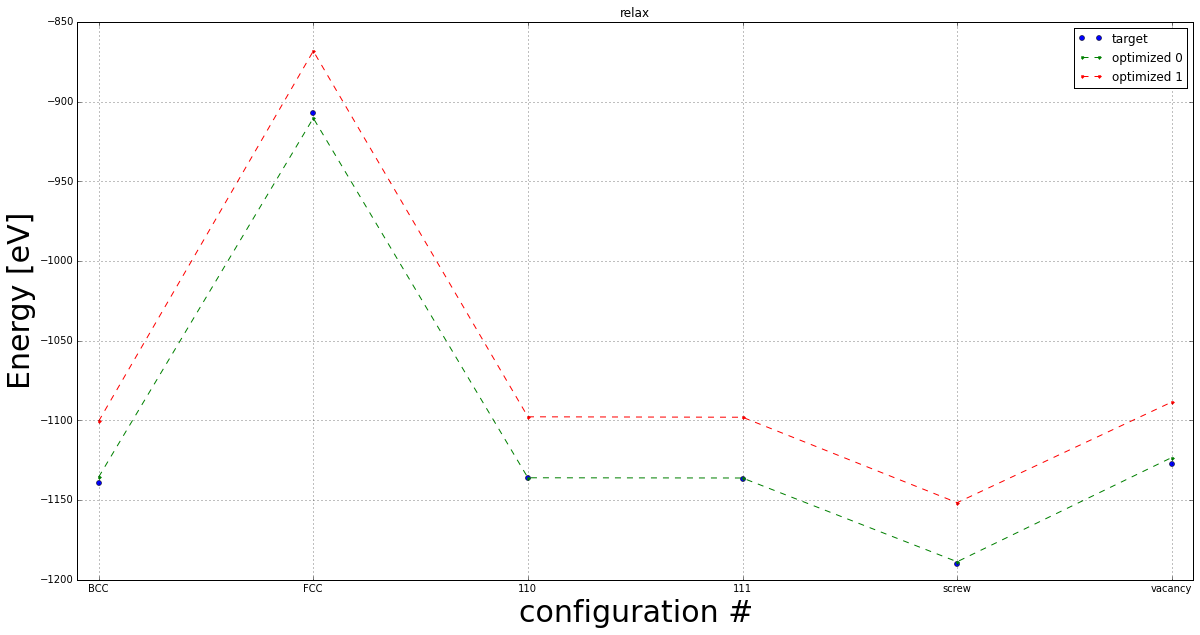

In [147]:
# plot relax
x_ticks = ([0, 1, 2, 3, 4, 5], ['BCC', 'FCC','110','111', 'screw', 'vacancy'])
x_lim=(-0.1, 5.1)
slice_end = len(x_ticks[0])
select = slice(0, slice_end, None)
plot_udif(targets, stats, 'relax', optimal_params, select=select, x_ticks=x_ticks, x_lim=x_lim, shift=-0)

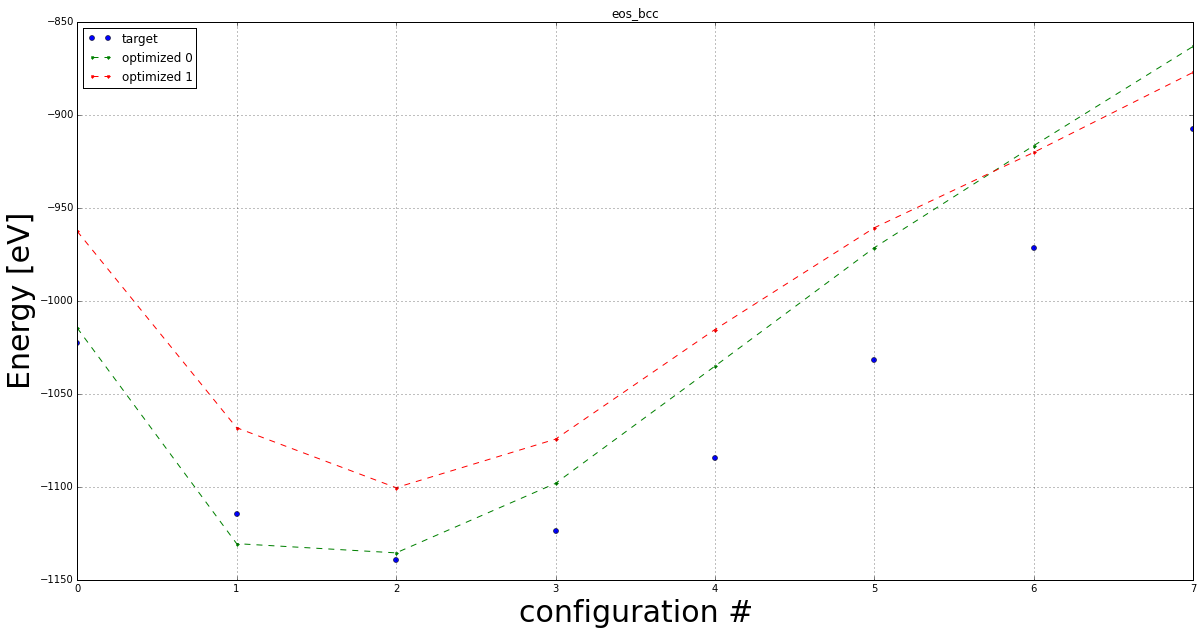

In [157]:
# plot bcc EOS
select = [10, 11, 6, 3, 4, 5, 7, 2, 1, 12, 13, 14, 15, 16, 17, 18]
select = [1, 2, 0, 3, 4, 5, 6, 7]
x_lim = (2, 8)
y_lim = (-9.0, -7.0)
plot_udif(targets, stats, 'eos_bcc', optimal_params, shift=-0, select=select)#, x_lim=x_lim, y_lim=y_lim)

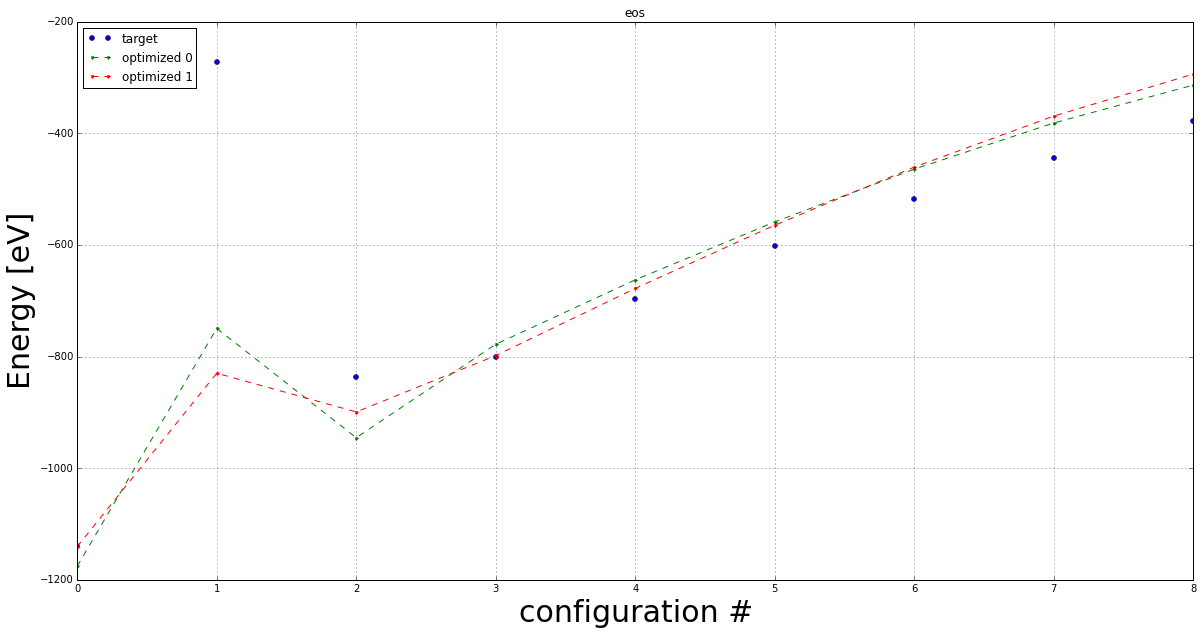

In [158]:
#select = [10, 11, 6, 3, 4, 5, 7, 2, 1, 12, 13, 14, 15, 16, 17, 18]
#x_lim = (2, 8)
#y_lim = (-9.0, -7.0)
plot_udif(targets, stats, 'eos', optimal_params, shift=-40)#, select=select)#, x_lim=x_lim, y_lim=y_lim)

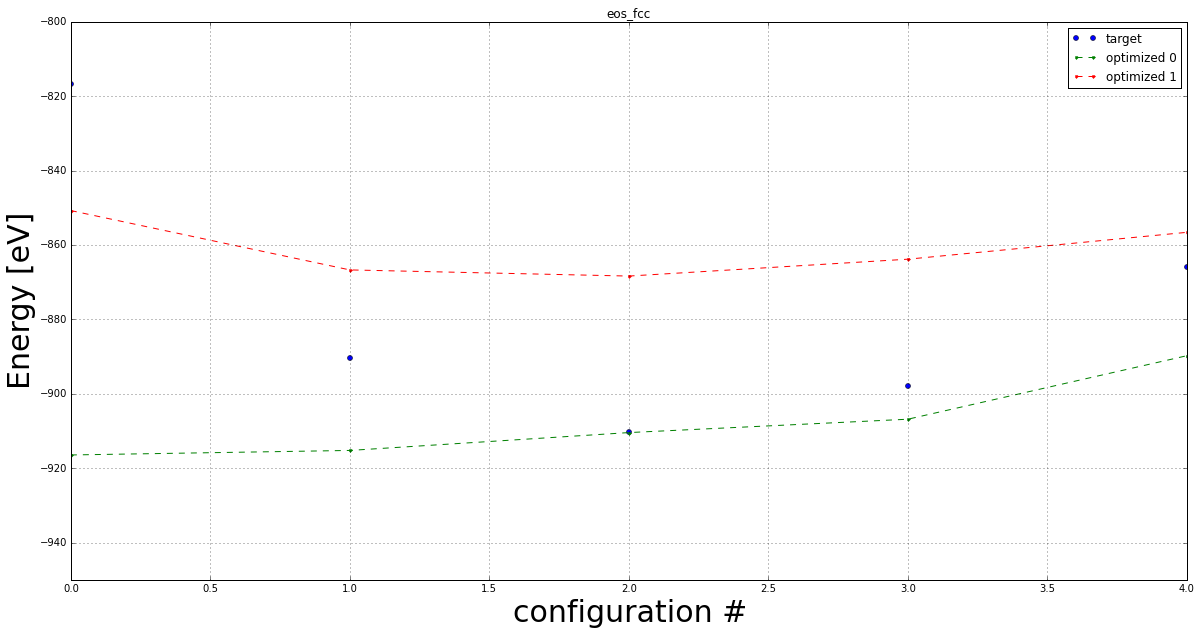

In [159]:
# plot fcc EOS
#select = [1, 2, 3, 0, 5, 6, 7, 4]
select = [1, 2, 0, 3, 4]
x_lim = (0, 4)
y_lim = (-950, -800)
plot_udif(targets, stats, 'eos_fcc', optimal_params, x_lim=x_lim, y_lim=y_lim, select=select, shift=-0)#, select=select)

In [160]:
# # plot MD trajectories
# x_lim = (2.8,8.2)
# y_lim = (-2250,-2100)
# #x_lim = (-0.2,2.2)
# #y_lim = (-3880,-3780)

# plot_udif(targets, stats, 'vacint', optimal_params, x_lim=x_lim, y_lim=y_lim)#, shift=-80)
# plot_udif(targets, stats, 'vacint', optimal_params, shift=-78, x_lim=x_lim, y_lim=y_lim)#, shift=-24.2)

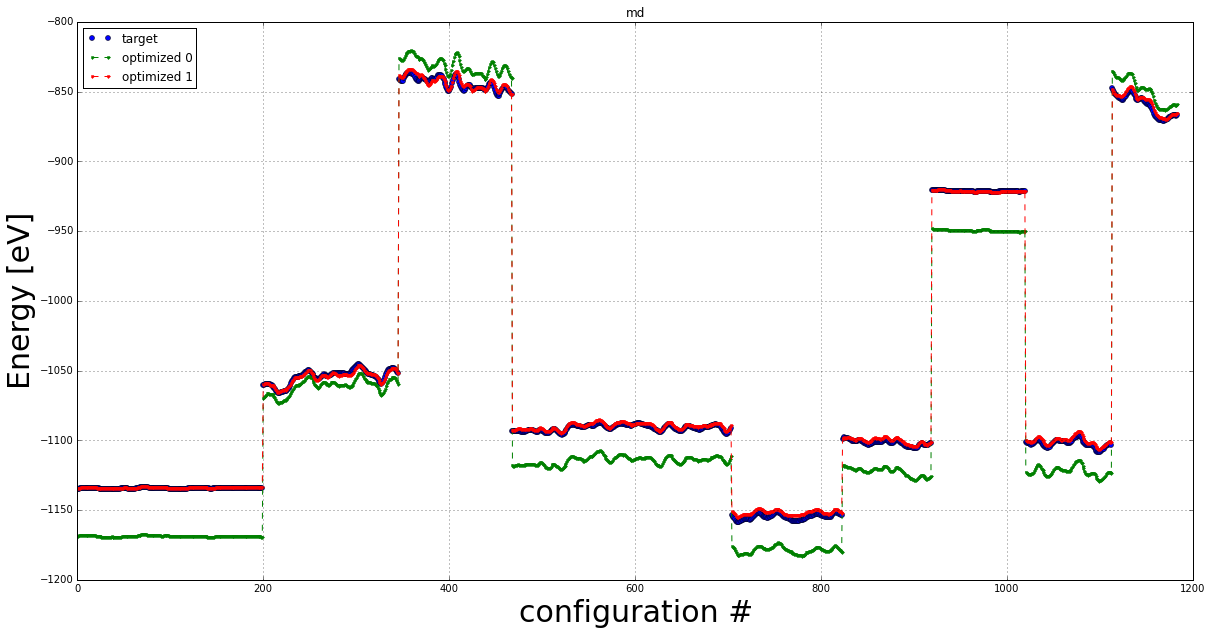

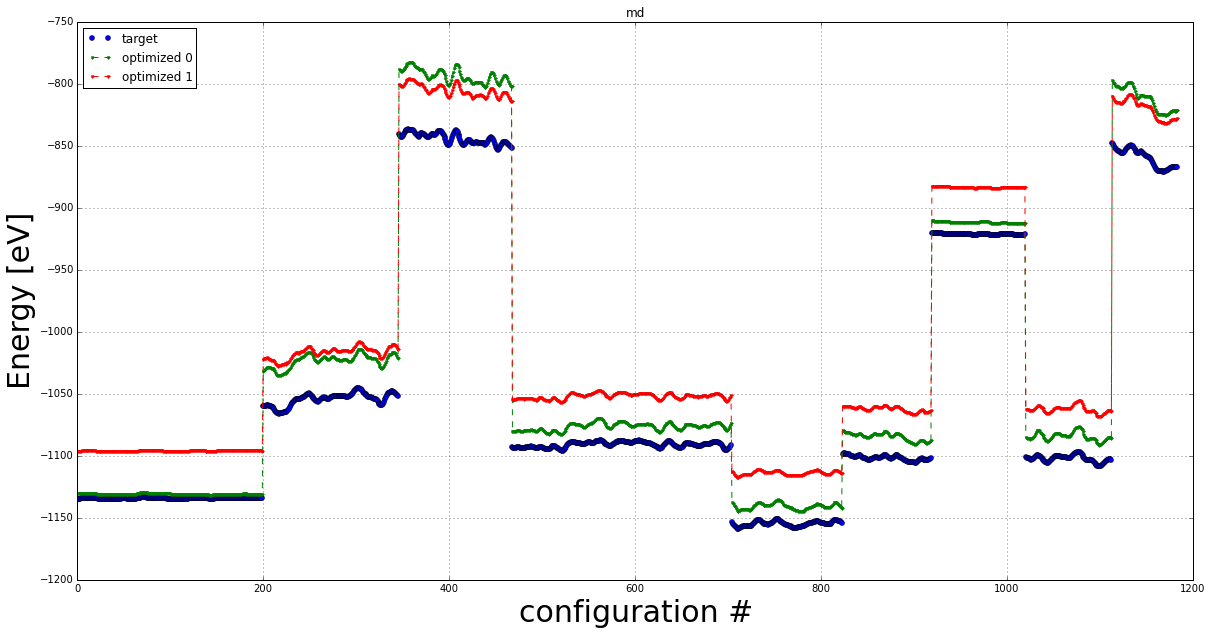

In [239]:
# plot MD trajectories
x_lim = (350,520)
#x_lim = (0,200)
#x_lim = (930, 1020)
#x_lim = (200, 380)
x_lim = (1120, 1200)
y_lim = (-900,-780)
#y_lim = (-1140,-1090)
#y_lim = (-940,-880)

plot_udif(targets, stats, 'md', optimal_params, shift=-38)#, x_lim=x_lim, y_lim=y_lim, shift=-39)
plot_udif(targets, stats, 'md', optimal_params)#, x_lim=x_lim, y_lim=y_lim, shift=-48)

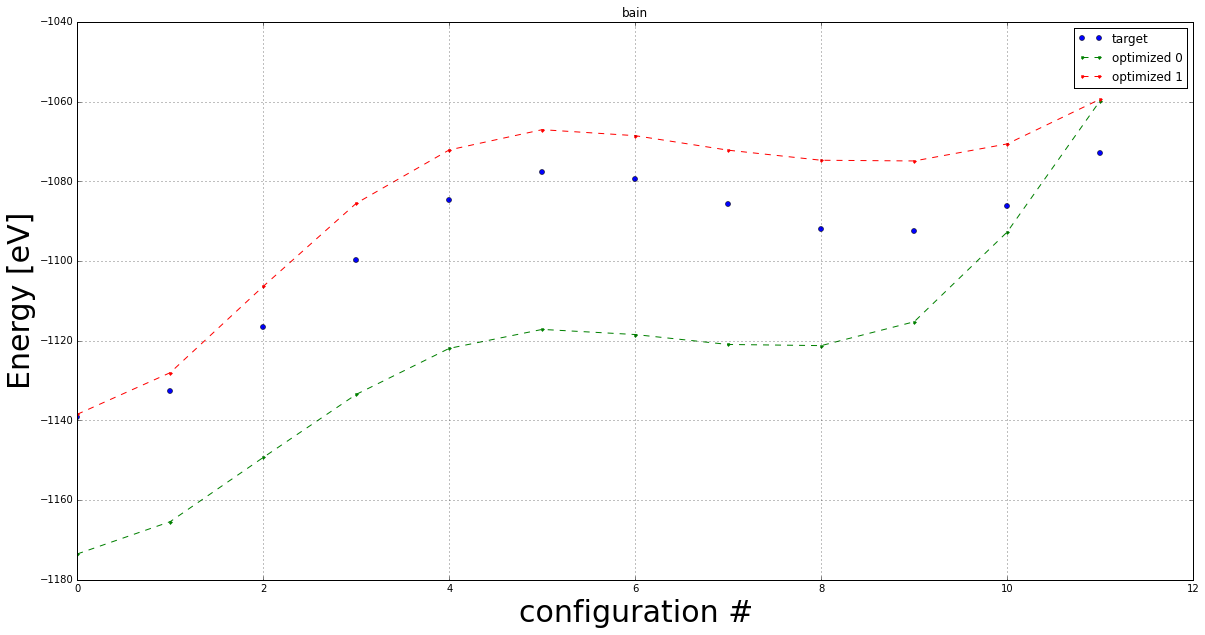

In [241]:
# plot MD trajectories
x_lim = (380,420)
y_lim = (-900,-780)
plot_udif(targets, stats, 'bain', optimal_params, shift=-38.0)#, x_lim=x_lim, y_lim=y_lim)

In [163]:
optimal_params

[(0.0, array([ -5.94645400e+00,  -4.94770000e-02,   9.60851701e+01,
          -1.84410924e+02,   9.35784080e+01,  -7.98358265e+00,
           7.47034093e+00,  -1.52756044e+00,   1.25205933e+00,
           1.63082162e+00,  -1.41854775e+00,  -8.19936046e-01,
           1.98013514e+00,  -6.96430180e-01,   3.04546910e-02,
          -1.63131143e+00,   1.38409896e+00,  -4.20429108e+00,
           5.18217702e-01,   5.62720800e-02,   3.44164179e-02])),
 (8.971006036356711e-07,
  array([ -4.18353755e+00,  -9.63668936e-03,  -1.00171035e+02,
           1.90025394e+01,   2.15938317e+01,  -1.39759833e+01,
           2.16332289e+01,  -3.29542126e+00,   1.70455674e+00,
           1.41347064e+00,  -9.02958785e-01,  -8.62309098e-01,
           1.95964588e+00,  -8.70527088e-01,   3.22342700e-02,
          -1.53866121e+00,   1.37095441e+00,  -4.32896107e+01,
           4.64461212e+00,   3.23329113e-01,   5.82061842e-02]))]

In [202]:
# select which parameters will be used for force field file
n_params = [2, 15, 4]
pars_out = to_param_dict(optimal_params[1][1], n_params)

In [203]:
pars_out['edens']

array([-43.2896107 ,   4.64461212,   0.32332911,   0.05820618])

In [204]:
optimal_list = []
optimal_list.append(pars_out)

In [232]:
optimal_list[-1]['edens'], stats['hyperparams']['pair']

[autoreload of statmechlib.forcefields.eam failed: Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "../../statmechlib/statmechlib/forcefields/eam.py", line 191
    u_total += np.array(sum([hc*ustats[i][4]]) for i in range(n_sample)])
                                                                       ^
SyntaxError: invalid syntax
]


(array([-43.2896107 ,   4.64461212,   0.32332911,   0.05820618]),
 [2.5648974999999998,
  2.6297950000000001,
  2.6946924999999999,
  2.8663175000000001,
  2.9730449999999999,
  3.0797724999999998,
  3.5164724999999999,
  3.8464450000000001,
  4.1764175000000003,
  4.7008450000000002,
  4.8952999999999998,
  5.0897550000000003,
  5.3429525,
  5.4016950000000001,
  5.4604375000000003])

In [206]:
# Total pair potential
pos = targets['relax']['xyz'][0]
bx = targets['relax']['box'][0]
rr, rx = pair_dist_cutoff(pos, bx, 5.5)

In [207]:
# embedding function
F = lambda d, a: a[0]*d**0.5 + a[1]*d**2

V = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

# Cohesive potential (cubic splines - same form as V)
phi = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc and r > 0.01])

rho = lambda r, aa, kk: sum([a*(rk - r)**3 for a, rk in zip(aa, kk) if r < rk and r > 0.01])

In [208]:
ff_id = -1

# spline knots
V_x_r = stats['hyperparams']['pair']
rho_x_r = stats['hyperparams']['edens']

# parameters
pair_y = optimal_list[ff_id]['pair']
many_y = optimal_list[ff_id]['embed']
rho_x_a = optimal_list[ff_id]['edens']

In [209]:
rho_x_a


array([-43.2896107 ,   4.64461212,   0.32332911,   0.05820618])

In [210]:
ene = []
for a in np.linspace(0.5, 2.0, 101):
    z = a*rr
    u_pair = 0.5*np.sum([V(x, pair_y, V_x_r) for x in z.flatten() if x > 0.1])

    u_many = 0.0
    for i in range(z.shape[0]):
        d = np.sum([phi(x, rho_x_a, rho_x_r) for x in z[i] if x > 0.1])
        u_many += F(d, many_y)

    ene.append([a, u_pair, u_many, u_pair+u_many])

ene = np.array(ene)

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


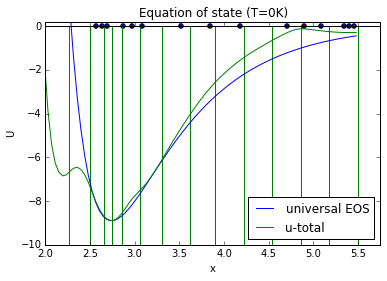

In [252]:
plt.title('Equation of state (T=0K)')

plt.plot(ene[:,0]*2.74, [universal_eos(x, 'W') for x in ene[:,0]], label='universal EOS')
plt.plot(ene[:,0]*2.74, ene[:,3]/128 - 0.3, label='u-total')
plt.scatter(stats['hyperparams']['pair'], np.zeros(len(stats['hyperparams']['pair'])))
#plt.vlines(stats['hyperparams']['pair'], -10, 0)

#plt.vlines(np.linspace(2.25, 5.5, 14), -10, 0, colors='r')
plt.vlines([2.26, 2.5 , 2.66, 2.74, 2.86, 3.06, 3.30, 3.62 , 3.9, 4.22, 4.54, 4.86, 5.18, 5.5], -10, 0, colors='g')


plt.hlines(0.0,0.5,6.0,lw=1)
plt.legend(loc='best')
plt.xlim(2.0, 5.75)
#plt.xlim(2.6, 2.85)
plt.ylim(-10,0.2)
#plt.ylim(-9.,-8.5)

plt.xlabel('x')
plt.ylabel(r'U')

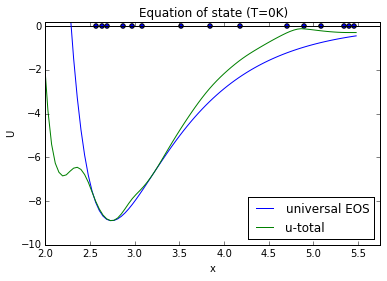

In [228]:
plt.title('Equation of state (T=0K)')
plt.plot(ene[:,0]*2.74, [universal_eos(x, 'W') for x in ene[:,0]], label='universal EOS')
plt.plot(ene[:,0]*2.74, ene[:,3]/128-0.3, label='u-total')
plt.scatter(stats['hyperparams']['pair'], np.zeros(len(stats['hyperparams']['pair'])))
plt.hlines(0.0,0.5,6.0,lw=1)
plt.legend(loc='best')
plt.xlim(2.0, 5.75)
#plt.xlim(2.6, 2.85)
plt.ylim(-10,0.2)
#plt.ylim(-9.,-8.5)

plt.xlabel('x')
plt.ylabel(r'U')

In [218]:
ff_id = -1

# spline knots
pair_r = stats['hyperparams']['pair']
rho_r = stats['hyperparams']['edens']

# parameters
pair_a = optimal_list[ff_id]['pair']
rho_a = optimal_list[ff_id]['edens']
many_a = optimal_list[ff_id]['embed']

In [219]:
# find electronic density maximum
rmax = max([(phi(r, rho_a, rho_r), r) for r in np.linspace(2.0, 4.9, 10000)])
rho_max, r_max = rmax
rho_max, r_max
rhomax = 12.0*phi(r_max, rho_a, rho_r)
rhomax

49.591759829005056

In [224]:
# Ranges of densities and separations

nr = 5000
rcut = pair_r[-1]#stats_opt['hyperparams'][-1]
dr = rcut/nr

rhomax = 12.0*phi(r_max, rho_a, rho_r)
print('rhomax:', rhomax)
rhomax = 10.0
nrho = 5000
drho = rhomax/nrho

ri = 1.0
ro = 2.0

# W properties
na = 74
ma = 183.84
lc = 3.1653
alat = 'bcc'

# System composition
n_el = 1
el_name = ['W']

('rhomax:', 49.591759829005056)


In [225]:
def u_trans(r, unucl, ueq, ri=1.0, ro=2.0):
    """Transition between the core and equillibrium potentials"""
    if r < ri:
        return unucl
    elif r < ro:
        x = (ro + ri - 2*r)/(ro - ri)
        eta = 3/16*x**5 - 5/8*x**3 + 15/16*x + 1/2
        return ueq + eta*(unucl - ueq)
    else:
        return ueq

In [226]:
# prepare lists of values
dens = np.linspace(0., rhomax-drho, nrho, endpoint=True)
r = np.linspace(0., rcut-dr, nr, endpoint=True)
r2 = np.linspace(0., rcut, 201)

fembd = [F(d, many_a) for d in dens] # W
edens = np.array([phi(x, rho_a, rho_r) if x > r_max else rho_max for x in r])

# 1. Cubic spline for r > r_o
f_outer = [V(x, pair_a, pair_r) for i, x in enumerate(r)]
# 2. Repulsive core for r < r_i (precalculate up to r_o)
f_inner = [0.0] + [u_core(x) for x in r[1:]]
# 3. Transition region for r_i < r < r_o
fpair = [x*u_trans(x, f_inner[i], f_outer[i]) for i, x in enumerate(r)]
#fpair = f_outer

In [227]:
# LAMMPS format
pot_path = '../sim/potentials'

with open(os.path.join(pot_path, 'W_nocorr.eam.fs'), 'w') as fo:
    
    # Comment section
    fo.write('Comment 1\n')
    fo.write('Comment 2\n')
    fo.write('Comment 3\n')
    
    # Number of elements
    #fo.write(f"{n_el:5d} ")
    fo.write("{0:5d} ".format(n_el))

    for i in range(n_el):
        #fo.write(f"{el_name[i]:2}")
        fo.write("{0:2}".format(el_name[i]))
    fo.write("\n")
    
    # number of grid points, step size, and cutoff
    #fo.write(f"{nrho:5d}{drho:24.16e}{nr:5d}{dr:24.16e}{rcut:24.16e}\n")
    fo.write("{0:5d}{1:24.16e}{2:5d}{3:24.16e}{4:24.16e}\n".format(nrho, drho, nr, dr, rcut))

    # atomic number, mass, lattice size, lattice type
    #fo.write(f"{na:5d} {ma:14.4f} {lc:14.4f} {alat:10}\n")
    fo.write("{0:5d} {1:14.4f} {2:14.4f} {3:10}\n".format(na, ma, lc, alat))

    
    # Embeding function
    for i in range(nrho//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fembd[i*4:i*4+4]))
    
    # Electronic density
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*edens[i*4:i*4+4]))
        
    # Pair potential
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fpair[i*4:i*4+4]))